In [1]:
from sklearn import datasets
import pandas as pd
from collections import Counter
import  matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import  LSTM, GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# Get the data
text_train = datasets.fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
text_valid = datasets.fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

Take a look at the data and notice it has newlines

In [5]:
print(text_train['data'][0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [6]:
text_train['data'][0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

So get rid of the newlines

In [7]:
print(text_train['data'][0].replace("\n"," "))

I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This is  all I know. If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail.


No one ever uses pandas!

In [8]:
X_train = pd.DataFrame({'message':text_train['data'],'class':text_train['target']})
x_valid = pd.DataFrame({'message':text_valid['data'],'class':text_valid['target']})

In [9]:
X_train['message'] = X_train['message'].str.replace("\n"," ")
x_valid['message'] = x_valid['message'].str.replace("\n"," ")

This helps if I want to change the vocabulary to have a word counter.  There are a number of ways to get a list of words.  This is mine.  Notice how I add in the 'popular' words for the pad and unknown words!

In [7]:
word_counts = Counter()

for i in range(X_train['message'].shape[0]):
    tmp = X_train.iloc[i,0].lower().split(" ")
    for i in tmp:
        word_counts[i] += 1

extra = Counter({"<pad>":10000001,"<unk>":1000000})
word_counts = word_counts + extra

Let's try the 5000 most common words!

In [8]:
words = word_counts.most_common(5000)

In [9]:
words

[('<pad>', 10000001),
 ('<unk>', 1000000),
 ('', 534730),
 ('the', 104353),
 ('to', 52023),
 ('of', 46412),
 ('a', 41954),
 ('and', 41189),
 ('in', 29912),
 ('is', 29220),
 ('i', 27330),
 ('that', 25774),
 ('for', 19345),
 ('it', 17439),
 ('you', 15621),
 ('on', 13642),
 ('be', 13444),
 ('this', 12929),
 ('are', 12593),
 ('have', 12588),
 ('with', 12272),
 ('not', 11445),
 ('as', 10986),
 ('or', 9628),
 ('was', 9297),
 ('but', 9101),
 ('if', 9068),
 ('they', 8585),
 ('by', 7923),
 ('from', 7743),
 ('at', 7437),
 ('an', 7151),
 ('can', 6658),
 ('will', 6465),
 ('my', 6099),
 ('would', 6061),
 ('what', 5885),
 ('-', 5738),
 ('he', 5554),
 ('all', 5518),
 ('about', 5480),
 ('we', 5450),
 ('there', 5441),
 ('one', 5388),
 ('has', 5325),
 ('your', 5221),
 ('do', 5207),
 ('some', 4666),
 ('any', 4631),
 ('\t', 4451),
 ('so', 4313),
 ('which', 4276),
 ('who', 4220),
 ('were', 3971),
 ('their', 3959),
 ('no', 3948),
 ('when', 3836),
 ('more', 3753),
 ('out', 3626),
 ("don't", 3625),
 ('just', 

Now I need a map of words to index--remember the word count is just COUNTS--words can have the same counts.
I create both the lookup and reverse at the same time.  There are lots of code snippits to reverse a dictionary, but since I am here...

In [10]:
lookup = {}
rev_lookup = {}
for i,j in enumerate(words):
    lookup[j[0]]=i
    rev_lookup[i] = j[0]

Now I just need a function that encodes words to numbers.  Its a for loop as a list comprehension.  List comprehensions are faster and more 'pythonic', but if they bother you, just write a for loop.

Another trick to shrink vocab is to make everything lower case or upper case.

In [11]:
def make_seq(string):
    return [lookup[i] if i in lookup.keys() else 1 for i in string.lower().split(" ") ]
"""
remeber "1" is the unknown token in my dictionary!
same thing:
seq = []
for i in string.lower().split(" "):
    if i in lookup.leys():
        seq.append(lookup[i])
    else:
        seq.append(1)
"""

'\nremeber "1" is the unknown token in my dictionary!\nsame thing:\nseq = []\nfor i in string.lower().split(" "):\n    if i in lookup.leys():\n        seq.append(lookup[i])\n    else:\n        seq.append(1)\n'

Make sure I translate back and forth ok

In [12]:
make_seq(X_train['message'][0])
check = make_seq(X_train['message'][0])
" ".join([rev_lookup[i] for i in check])

'i was wondering if anyone out there could <unk> me on this car i saw the other day. it was a <unk> sports car, looked to be from the late <unk> early <unk> it was called a <unk> the doors were really <unk> in addition, the front <unk> was separate from the rest of the body. this is  all i know. if anyone can <unk> a model name, engine <unk> years of <unk> where this car is made, history, or whatever info you have on this <unk> looking car, please e-mail.'

In [13]:
X_train['message'][0]

'I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This is  all I know. If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail.'

So make some sequences

In [14]:
X_train['sequence'] = X_train['message'].apply(make_seq)
x_valid['sequence'] = x_valid['message'].apply(make_seq)

In [15]:
# a  little outta place, I wondered what all these short sequences were
X_train[X_train['message'].apply(len)==1]

,message,class,sequence
252,,0,"[2, 2]"
599,,2,"[2, 2]"
800,,7,"[2, 2]"
929,,3,"[2, 2]"
1204,,2,"[2, 2]"
2308,,18,"[2, 2]"
2368,,7,"[2, 2]"
2500,,16,"[2, 2]"
2984,,15,"[2, 2]"
3753,,12,"[2, 2]"


(array([228.,  60.,  27.,  33.,  25.,  30.,  36.,  42.,  39.,  31.,  42.,
         30.,  45.,  49.,  67.,  47.,  56.,  52.,  42.,  50.,  65.,  53.,
         59.,  61.,  70.,  67.,  65.,  57.,  64.,  77.,  78.,  72.,  77.,
         65.,  78.,  81.,  69.,  70.,  76.,  72.,  66.,  79.,  94.,  68.,
         72.,  72.,  70.,  69.,  78.,  72.,  54.,  74.,  86.,  62.,  65.,
         76.,  61.,  71.,  67.,  50.,  60.,  71.,  48.,  73.,  58.,  47.,
         64.,  67.,  70.,  55.,  68.,  54.,  56.,  49.,  56.,  43.,  52.,
         40.,  49.,  46.,  44.,  51.,  47.,  38.,  41.,  64.,  55.,  47.,
         46.,  50.,  44.,  46.,  46.,  49.,  43.,  30.,  57.,  39.,  51.,
         28.,  49.,  34.,  34.,  28.,  41.,  41.,  40.,  34.,  44.,  47.,
         45.,  32.,  39.,  41.,  28.,  40.,  39.,  40.,  32.,  33.,  36.,
         26.,  27.,  36.,  35.,  34.,  31.,  26.,  39.,  29.,  35.,  36.,
         32.,  23.,  36.,  35.,  22.,  28.,  25.,  39.,  35.,  40.,  26.,
         31.,  36.,  24.,  24.,  25., 

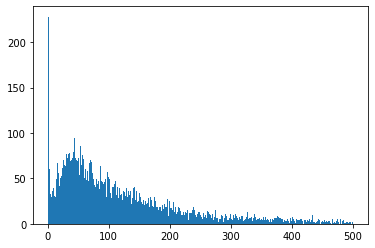

In [16]:
# a histogram!
my_bins = np.linspace(1,500,500)
plt.hist(X_train['sequence'].apply(len),bins=my_bins)

How is class balance?  Not too bad

In [17]:
X_train['class'].value_counts()

10    600
15    599
8     598
9     597
11    595
7     594
13    594
5     593
14    593
2     591
12    591
3     590
6     585
1     584
4     578
17    564
16    546
0     480
18    465
19    377
Name: class, dtype: int64

Find my sequence length

I tried 99, 95, and 90--the sequences were really long, so I did 90.

In [18]:
np.quantile(X_train['sequence'].apply(len),.90)

401.0

Pad them to 400 or chop down to 400.  Default pad is 0 which I used, so no need to tell it what the pad number is

In [19]:
max_length = 400
X_train_data = sequence.pad_sequences(X_train['sequence'], maxlen=max_length)
x_valid_data = sequence.pad_sequences(x_valid['sequence'], maxlen=max_length)

In [20]:
# create the model
es = EarlyStopping(patience=5)
vector_size = 101 #even numbers are for losers!
model = Sequential()
model.add(Embedding(5000, vector_size, input_length=max_length))
model.add(GRU(100)) #I started with LSTM for speed, but GRU gave better results.  No Free Lunch!
model.add(Dropout(0.30)) #this thing overtrains hard, so Dropout is your regularization in NN
model.add(Dense(500,activation='relu'))
model.add(Dropout(0.30))
model.add(Dense(20, activation='softmax'))
#I threw in the top k accuracy to show that while results aren't great, it is getting things mostly right 
# annd just confusing similar tasks.
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy','sparse_top_k_categorical_accuracy'])
print(model.summary())
model.fit(X_train_data, X_train['class'], validation_data=(x_valid_data, x_valid['class']), 
          epochs=300, batch_size=64, callbacks=[es])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 101)          505000    
_________________________________________________________________
gru (GRU)                    (None, 100)               60900     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               50500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                10020     
Total params: 626,420
Trainable params: 626,420
Non-trainable params: 0
__________________________________________________

In [21]:
preds = np.argmax(model.predict(x_valid_data),axis=1)

In [22]:
preds

array([ 4,  1,  2, ...,  8,  6, 15], dtype=int64)

In [23]:
v = confusion_matrix(x_valid['class'], preds, normalize='true')

In [24]:
plot = ConfusionMatrixDisplay(v,display_labels=text_train['target_names'])

Make it big and make it readable.

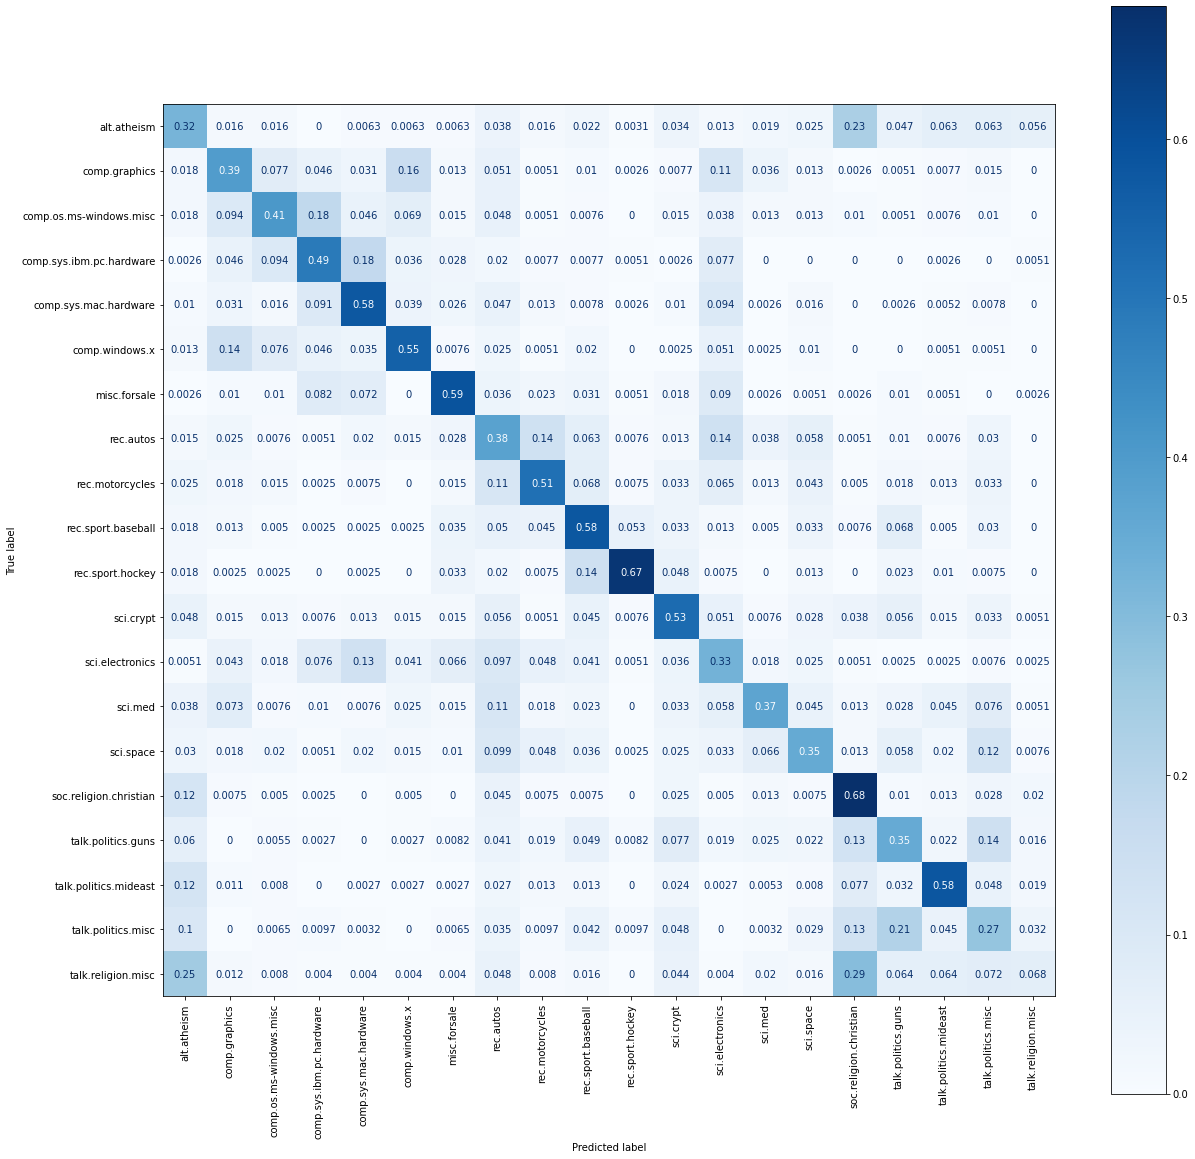

In [25]:
plt.rcParams["figure.figsize"] = (20,20)
plot.plot(xticks_rotation='vertical',cmap='Blues')
plt.show()

## Professor Flex
Previous was the standard RNN style processing.  Not bad, but not great.  Now we get to modern transfer learning and Transformer based NLP.  The Universal Sentence Encode takes a series of text and makes a sentence vector.  It combines all of your words into a representation that has 512 dense numbers.

From there we can then pass those numbers as inputs to dense layers.  In essence, USE acts an a feature generator for us, and the result despite severely abusing the term 'sentence' is greatly improved.

Notice also this takes text in directly, so i don't have to worry about sequences or mapping words to numbers.
Very nice!

Paper:
https://arxiv.org/pdf/1803.11175.pdf

### Do note the first time this is run, the model is downloaded--there models are in the 100+ MB range so it can take a bit

In [27]:
import tensorflow_hub as hub
import tensorflow as tf

module_path = "https://tfhub.dev/google/universal-sentence-encoder/4"
embedding_layer = hub.KerasLayer(module_path, trainable=False)

model = Sequential()
model.add(tf.keras.layers.Input(shape=[], dtype=tf.string))
model.add(embedding_layer)
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(20, activation="softmax"))

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 20)                1300      
Total params: 256,873,044
Trainable params: 75,220
Non-trainable params: 256,797,824
_________________________________________________________________


In [29]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy','sparse_top_k_categorical_accuracy'])
print(model.summary())
model.fit(X_train['message'], X_train['class'], validation_data=(x_valid['message'], x_valid['class']), 
          epochs=300, batch_size=64, callbacks=[es])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 20)                1300      
Total params: 256,873,044
Trainable params: 75,220
Non-trainable params: 256,797,824
_________________________________________________________________
None
Epoch 1/300
177/177 [==============================] - 42s 228ms/step - loss: 1.9950 - accuracy: 0.4502 - sparse_top_k_categorical_accuracy: 0.7675 - val_loss: 1.2779 - val_accuracy: 0.6136 - val_sparse_top_k_categorical_accurac

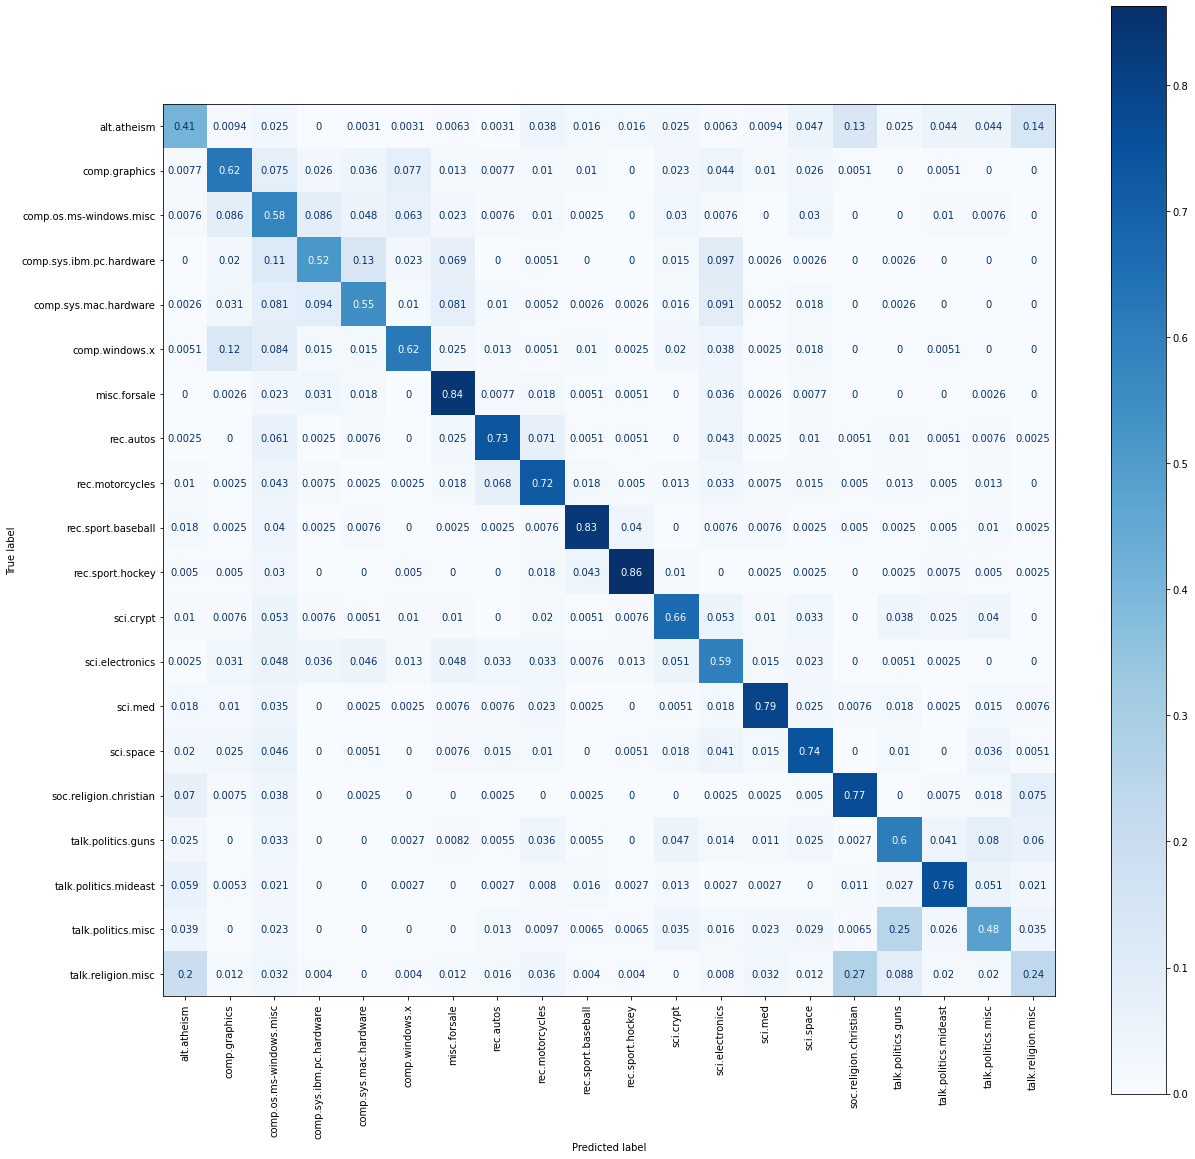

In [30]:
preds = np.argmax(model.predict(x_valid['message']),axis=1)
v = confusion_matrix(x_valid['class'], preds, normalize='true')
plot = ConfusionMatrixDisplay(v,display_labels=text_train['target_names'])
plt.rcParams["figure.figsize"] = (20,20)
plot.plot(xticks_rotation='vertical',cmap='Blues')
plt.show()

## Mecha-Streisand Flex
Why not use one of the most famous models in the world?  The Bi-directional Encoding Represantive Transformer (BERT).  This shows how to download BERT and then use it as a classifier.
If you wanted individual word vectors you would use the 'sequence' output.  The pooled out is the special classifier of BERT.  Be sure to read the paper or pester your favorite NLP professor about the details as you do need the preprocessor to use the special tokenizer for BERT and recongize it has a special '\<CLS\>' token for classification that always appears first so you can always use the first (address ZERO) sequence output.  Happily this is done for us, but its always good to know the details.

The best way to try this is to use a low learning rate and set training to true.  I ran out of time preparing this, but I left the code below as an example.

https://arxiv.org/abs/1810.04805

This thing is BIG and even causes GPUs to go 'NO THANKS'


Note that this requires tensoflow 2.6 or less because tensorflow likes to forget things like the 'core' module of tensorflow_text in their releases
https://github.com/tensorflow/text/issues/771

In [23]:
from tensorflow.keras.layers import Input
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import constant,string
es = EarlyStopping(patience=2)
text_input = Input(shape=(), dtype=string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=False)  #RIP my GPU if set to True--runs out of memory with batch size >8 if true!
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"] # [batch_size, 768].
outputs = Dense(512,activation='relu')(pooled_output)
outputs = Dense(20,activation='softmax')(pooled_output)
#sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].
embedding_model = Model(text_input, outputs)
embedding_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy','sparse_top_k_categorical_accuracy'])

In [24]:
embedding_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_6 (KerasLayer)      {'input_type_ids': ( 0           input_4[0][0]                    
__________________________________________________________________________________________________
keras_layer_7 (KerasLayer)      {'pooled_output': (N 109482241   keras_layer_6[0][0]              
                                                                 keras_layer_6[0][1]              
                                                                 keras_layer_6[0][2]              
____________________________________________________________________________________________

In [25]:
#Why 8? thats the biggest batch size that fits!!
#Never mind--training all of BERT gave me very low accuracy--just using transfer learning for now.
embedding_model.fit(X_train['message'], X_train['class'], validation_data=(x_valid['message'], x_valid['class']), 
          epochs=300, batch_size=64, callbacks=[es])

Epoch 1/300
177/177 [==============================] - 246s 1s/step - loss: 2.8809 - accuracy: 0.1240 - sparse_top_k_categorical_accuracy: 0.4197 - val_loss: 2.7536 - val_accuracy: 0.1799 - val_sparse_top_k_categorical_accuracy: 0.4930
Epoch 2/300
177/177 [==============================] - 236s 1s/step - loss: 2.6316 - accuracy: 0.2340 - sparse_top_k_categorical_accuracy: 0.5932 - val_loss: 2.5426 - val_accuracy: 0.2777 - val_sparse_top_k_categorical_accuracy: 0.6560
Epoch 3/300
177/177 [==============================] - 238s 1s/step - loss: 2.4549 - accuracy: 0.3016 - sparse_top_k_categorical_accuracy: 0.6843 - val_loss: 2.4225 - val_accuracy: 0.2920 - val_sparse_top_k_categorical_accuracy: 0.6579
Epoch 4/300
177/177 [==============================] - 232s 1s/step - loss: 2.3174 - accuracy: 0.3521 - sparse_top_k_categorical_accuracy: 0.7247 - val_loss: 2.2995 - val_accuracy: 0.3477 - val_sparse_top_k_categorical_accuracy: 0.7246
Epoch 5/300
177/177 [==============================] - 2

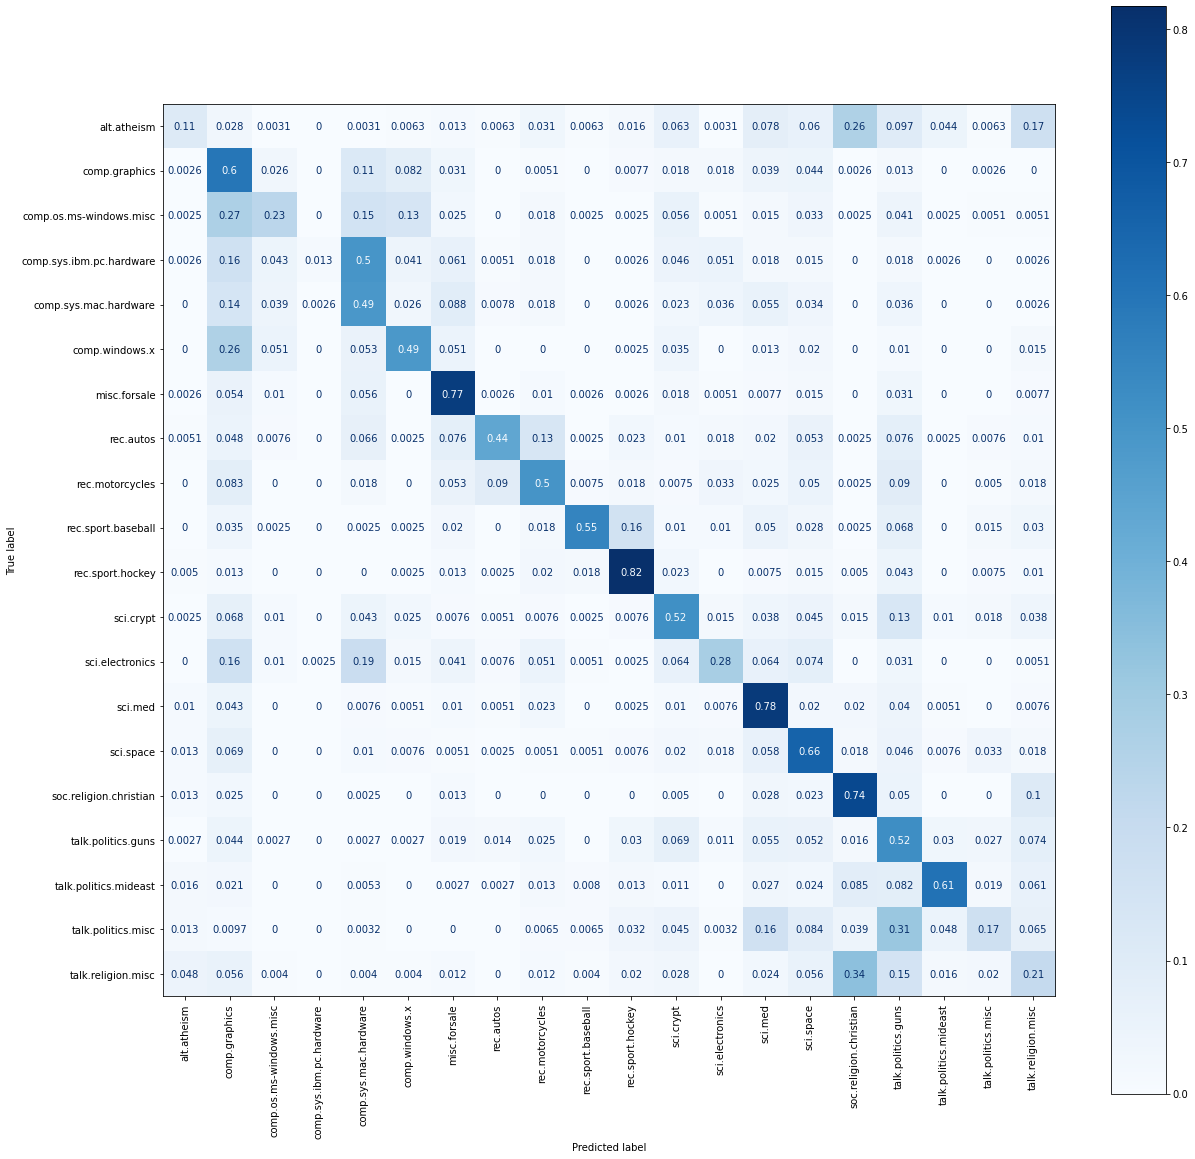

In [26]:
preds = np.argmax(embedding_model.predict(x_valid['message']),axis=1)
v = confusion_matrix(x_valid['class'], preds, normalize='true')
plot = ConfusionMatrixDisplay(v,display_labels=text_train['target_names'])
plt.rcParams["figure.figsize"] = (20,20)
plot.plot(xticks_rotation='vertical',cmap='Blues')
plt.show()

## Low Learning Rate

Maybe try this on google colab with a TPU (GPU on steroids)

In [29]:
from tensorflow.keras.optimizers import Adam
es = EarlyStopping(patience=2)
text_input = Input(shape=(), dtype=string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=True)  #RIP my GPU if set to True--runs out of memory with batch size >8 if true!
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"] # [batch_size, 768].
outputs = Dense(512,activation='relu')(pooled_output)
outputs = Dense(20,activation='softmax')(pooled_output)
#sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].
embedding_model = Model(text_input, outputs)
adam = Adam(lr=0.000001) # with transfer learning you want a very low learning rate to 'fine-tune'
embedding_model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy','sparse_top_k_categorical_accuracy'])

G:\.bert\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [30]:
#Why 8? thats the biggest batch size that fits!!
#Never mind--training all of BERT gave me very low accuracy--just using transfer learning for now.
embedding_model.fit(X_train['message'], X_train['class'], validation_data=(x_valid['message'], x_valid['class']), 
          epochs=300, batch_size=8, callbacks=[es])

Epoch 1/300
1415/1415 [==============================] - 380s 260ms/step - loss: 2.7990 - accuracy: 0.1593 - sparse_top_k_categorical_accuracy: 0.4529 - val_loss: 2.2279 - val_accuracy: 0.3883 - val_sparse_top_k_categorical_accuracy: 0.7541
Epoch 2/300
1415/1415 [==============================] - 366s 259ms/step - loss: 1.8222 - accuracy: 0.5128 - sparse_top_k_categorical_accuracy: 0.8433 - val_loss: 1.5207 - val_accuracy: 0.5817 - val_sparse_top_k_categorical_accuracy: 0.8764
Epoch 3/300
1415/1415 [==============================] - 367s 259ms/step - loss: 1.3705 - accuracy: 0.6171 - sparse_top_k_categorical_accuracy: 0.8992 - val_loss: 1.2959 - val_accuracy: 0.6292 - val_sparse_top_k_categorical_accuracy: 0.8938
Epoch 4/300
1415/1415 [==============================] - 367s 259ms/step - loss: 1.1662 - accuracy: 0.6632 - sparse_top_k_categorical_accuracy: 0.9159 - val_loss: 1.1749 - val_accuracy: 0.6515 - val_sparse_top_k_categorical_accuracy: 0.9011
Epoch 5/300
1415/1415 [=============

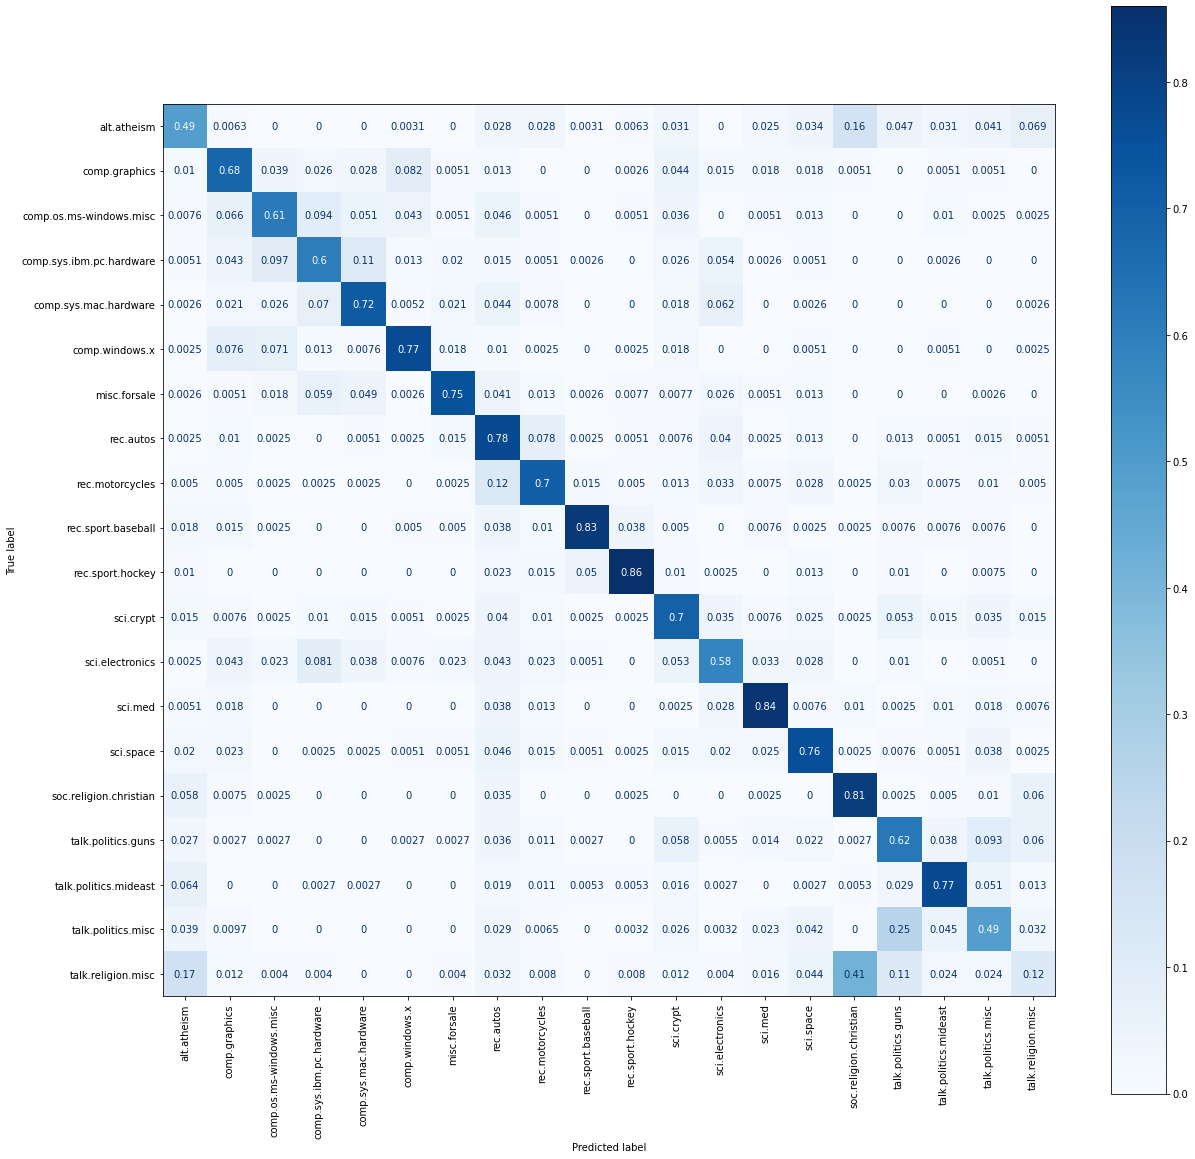

In [31]:
preds = np.argmax(embedding_model.predict(x_valid['message']),axis=1)
v = confusion_matrix(x_valid['class'], preds, normalize='true')
plot = ConfusionMatrixDisplay(v,display_labels=text_train['target_names'])
plt.rcParams["figure.figsize"] = (20,20)
plot.plot(xticks_rotation='vertical',cmap='Blues')
plt.show()